In [1]:
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from collections import defaultdict

BASE = "/home/hep/an1522/dark_tridents_wspace/outputs/inference"

MODELS = {
    "DM-CNN": {
        "bkg_dir": os.path.join(BASE, "run3_samples_mpid"),
        "sig_dir": os.path.join(BASE, "run3_signal_mpid"),
    },
    "ResNet18-GN": {
        "bkg_dir": os.path.join(BASE, "run3_samples_resnet18_gn"),
        "sig_dir": os.path.join(BASE, "run3_signal_resnet18_gn"),
    },
    "ResNet18-BN": {
        "bkg_dir": os.path.join(BASE, "run3_samples_resnet18_bn"),
        "sig_dir": os.path.join(BASE, "run3_signal_resnet18_bn"),
    },
    "ResNet34-GN": {
        "bkg_dir": os.path.join(BASE, "run3_samples_resnet34_gn"),
        "sig_dir": os.path.join(BASE, "run3_signal_resnet34_gn"),
    },
    "ResNet34-BN": {
        "bkg_dir": os.path.join(BASE, "run3_samples_resnet34_bn"),
        "sig_dir": os.path.join(BASE, "run3_signal_resnet34_bn"),
    },
}

SCORE_COL = "signal_score"

BKG_COMPONENTS = {
    "nu overlay": ["nu_overlay"],
    "off beam":   ["offbeam"],
    "dirt":       ["dirt"],
}

In [2]:
def load_scores_csv(csv_path, score_col="signal_score"):
    df = pd.read_csv(csv_path)
    s = pd.to_numeric(df[score_col], errors="coerce").to_numpy()
    s = s[np.isfinite(s)]
    s = s[s >= 0.0]   # drop placeholders like -999999.9
    return s

def load_background_scores(bkg_dir, score_col="signal_score"):
    bkg_dir = Path(bkg_dir)
    files = sorted(bkg_dir.glob("*_scores.csv"))
    if not files:
        raise FileNotFoundError(f"No *_scores.csv found in {bkg_dir}")
    all_scores = [load_scores_csv(f, score_col=score_col) for f in files]
    return np.concatenate(all_scores)

def load_background_scores_by_component(bkg_dir, score_col="signal_score", components=BKG_COMPONENTS):
    bkg_dir = Path(bkg_dir)
    files = sorted(bkg_dir.glob("*_scores.csv"))
    if not files:
        raise FileNotFoundError(f"No *_scores.csv found in {bkg_dir}")
    out = {k: [] for k in components.keys()}
    unmatched = []
    for f in files:
        fname = f.name.lower()
        matched = False
        for comp, keys in components.items():
            if any(k in fname for k in keys):
                out[comp].append(load_scores_csv(f, score_col=score_col))
                matched = True
                break
        if not matched:
            unmatched.append(f.name)
    # concatenate arrays
    out = {k: (np.concatenate(v) if len(v) else np.array([], dtype=float)) for k, v in out.items()}
    if unmatched:
        print("[warn] background files not matched to a component:")
        for u in unmatched[:20]:
            print("  ", u)
        if len(unmatched) > 20:
            print(f"  ... and {len(unmatched)-20} more")
    # sanity prints
    for k, arr in out.items():
        print(f"  {k}: {len(arr)} events")
    return out

def compute_roc_auc(bkg_scores, sig_scores):
    y_true = np.r_[np.zeros(len(bkg_scores)), np.ones(len(sig_scores))].astype(int)
    y_score = np.r_[bkg_scores, sig_scores].astype(float)
    fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=False)
    return fpr, tpr, auc(fpr, tpr)

def parse_ratio_mass_from_name(fname):
    # expects something like run1_dt_ratio_0.6_ma_0.01_pi0_larcv_cropped_scores.csv
    m = re.search(r"dt_ratio_([0-9.]+)_ma_([0-9.]+)_", fname)
    if not m:
        return None, None
    return float(m.group(1)), float(m.group(2))


In [3]:
bkg_scores = {}
for model_name, cfg in MODELS.items():
    print(model_name)
    bkg_scores[model_name] = load_background_scores_by_component(cfg["bkg_dir"], score_col=SCORE_COL)


DM-CNN
  nu overlay: 11525 events
  off beam: 15437 events
  dirt: 2412 events
ResNet18-GN
  nu overlay: 11525 events
  off beam: 15437 events
  dirt: 2412 events
ResNet18-BN
  nu overlay: 11525 events
  off beam: 15437 events
  dirt: 2412 events
ResNet34-GN
  nu overlay: 11525 events
  off beam: 15437 events
  dirt: 2412 events
ResNet34-BN
  nu overlay: 11525 events
  off beam: 15437 events
  dirt: 2412 events


<Figure size 700x700 with 0 Axes>

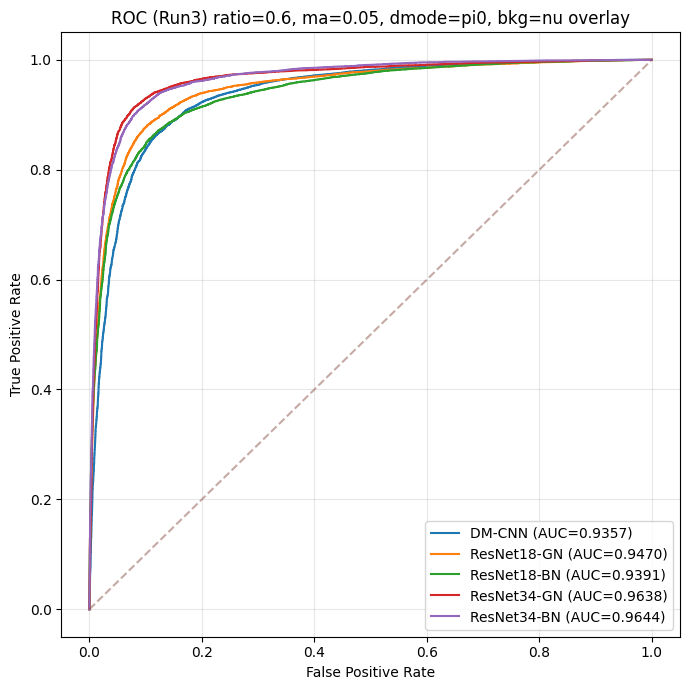

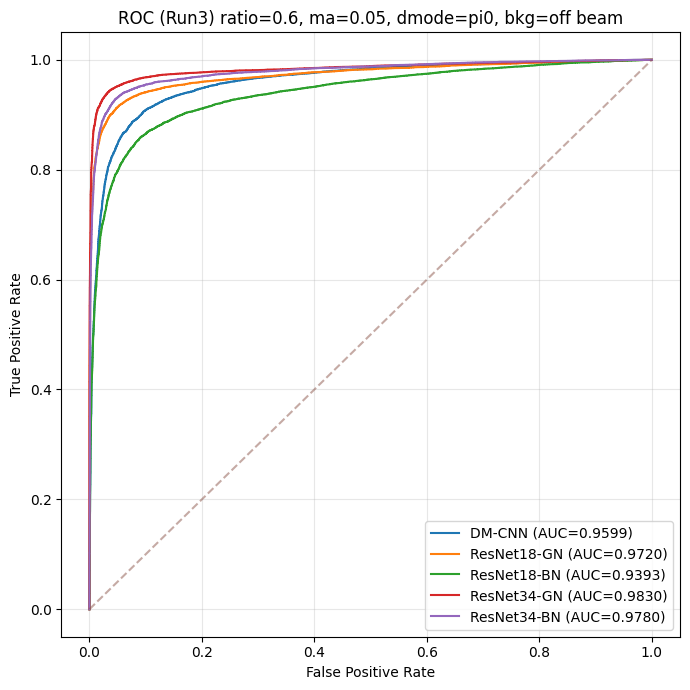

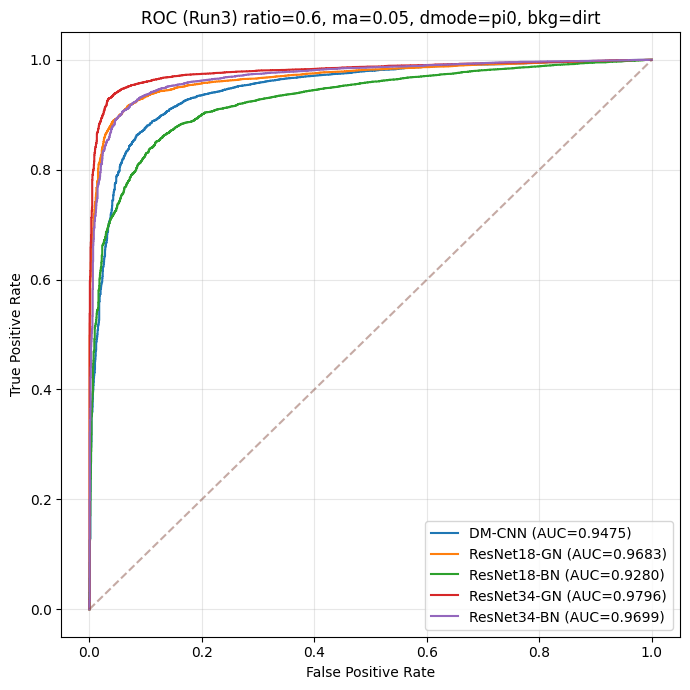

In [4]:
# parse ratio, mass, dmode from filename
def parse_ratio_mass_dmode(fname):
    m = re.search(r"dt_ratio_([0-9.]+)_ma_([0-9.]+)_(pi0|eta)_", fname)
    if not m:
        return None, None, None
    return float(m.group(1)), float(m.group(2)), m.group(3)

TARGET_MASS = 0.05
RATIO = 0.6   # or 2.0
DMODE = "pi0" # "pi0" or "eta"

# collect signal files for DM-CNN folder
sig_files = sorted(Path(MODELS["DM-CNN"]["sig_dir"]).glob("*_scores.csv"))

# find the DM-CNN signal file matching ratio + mass + dmode
f_dmcnn = None
for f in sig_files:
    ratio, mass, dmode = parse_ratio_mass_dmode(f.name)
    if ratio is None:
        continue
    if (abs(ratio - RATIO) < 1e-9) and (abs(mass - TARGET_MASS) < 1e-9) and (dmode == DMODE):
        f_dmcnn = f
        break

if f_dmcnn is None:
    raise FileNotFoundError(f"No signal file found for ratio={RATIO}, ma={TARGET_MASS}, dmode={DMODE}")

plt.figure(figsize=(7, 7))

for comp in BKG_COMPONENTS.keys():
    plt.figure(figsize=(7, 7))

    for model_name, cfg in MODELS.items():
        f_sig = Path(cfg["sig_dir"]) / f_dmcnn.name
        if not f_sig.exists():
            print(f"[skip] missing for {model_name}: {f_sig.name}")
            continue

        sig = load_scores_csv(f_sig, score_col=SCORE_COL)
        bkg = bkg_scores[model_name][comp]

        if len(bkg) == 0:
            print(f"[skip] no {comp} background for {model_name}")
            continue

        fpr, tpr, auc_val = compute_roc_auc(bkg, sig)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_val:.4f})")

    plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC (Run3) ratio={RATIO}, ma={TARGET_MASS}, dmode={DMODE}, bkg={comp}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    out_dir = "/home/hep/an1522/dark_tridents_wspace/outputs/roc_auc"
    os.makedirs(out_dir, exist_ok=True)
    
    plt.savefig(
        os.path.join(out_dir, f"ROC_ratio_{RATIO}_ma_{TARGET_MASS}_{DMODE}_{comp}_run3.png"),
        dpi=200,
        bbox_inches="tight",
    )
    
    plt.show()


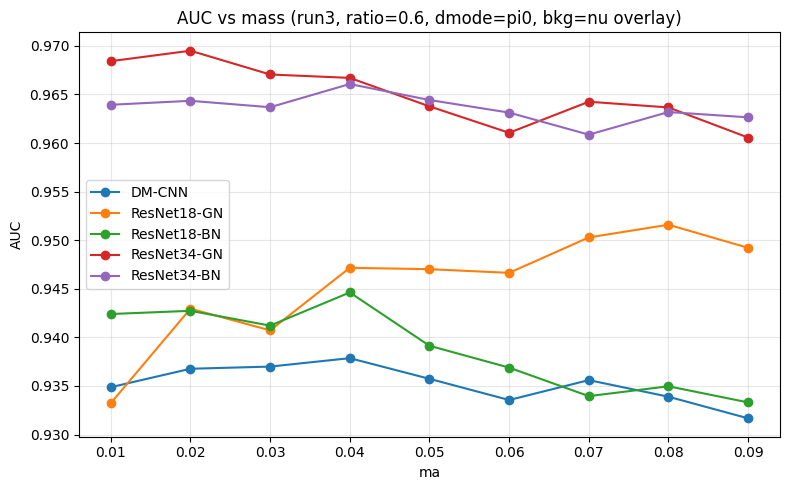

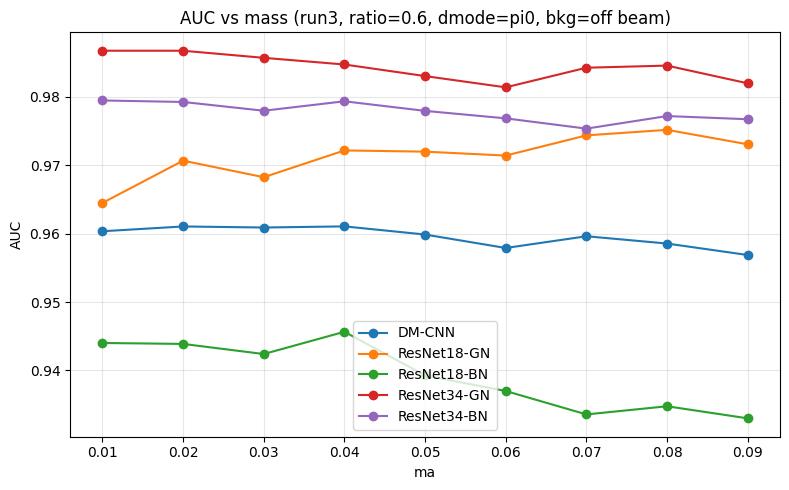

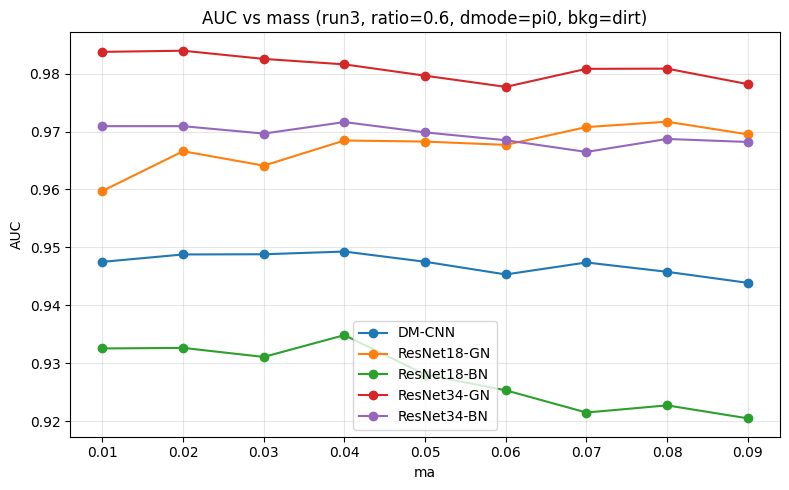

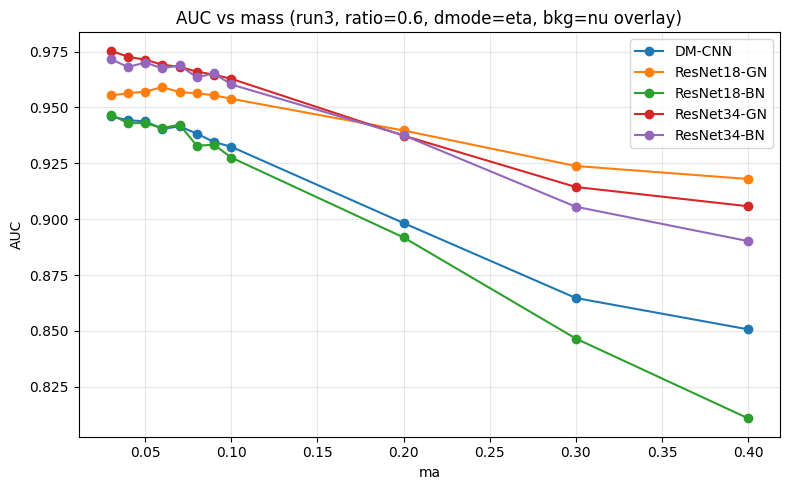

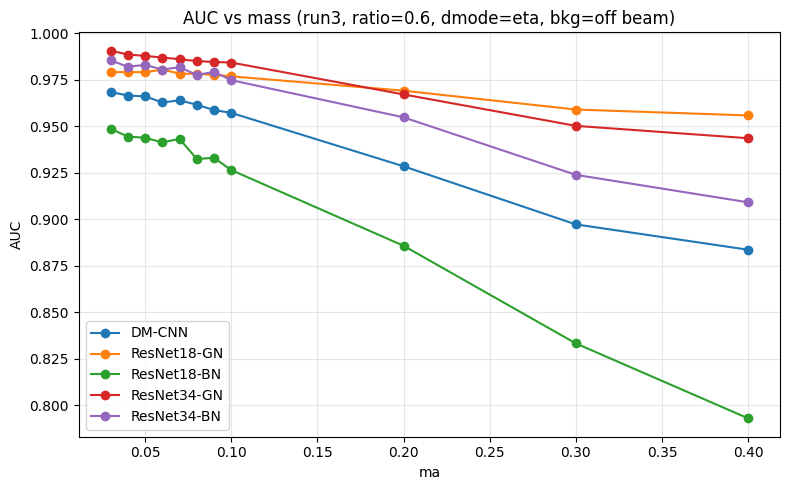

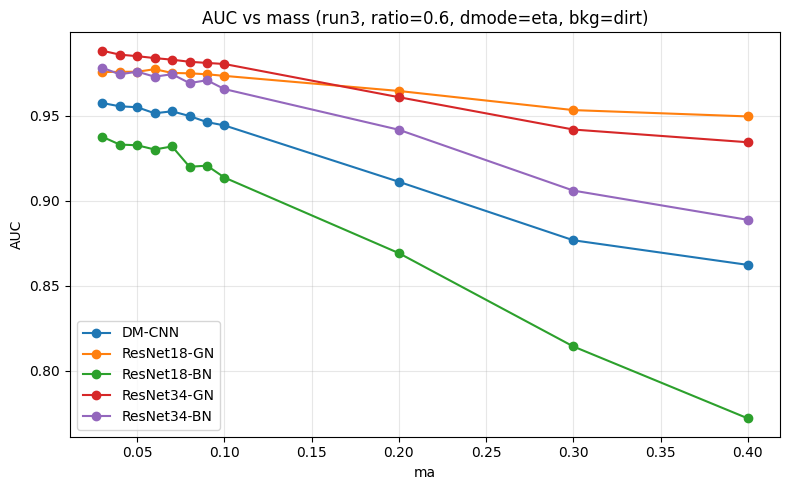

In [5]:
def parse_ratio_mass_dmode(fname):
    m = re.search(r"dt_ratio_([0-9.]+)_ma_([0-9.]+)_(pi0|eta)_", fname)
    if not m:
        return None, None, None
    return float(m.group(1)), float(m.group(2)), m.group(3)

RATIO = 0.6  # or 2.0
BKG_ORDER = ["nu overlay", "off beam", "dirt"]  # must match your dict keys

# AUC storage: auc_vs_mass[dmode][bkg_comp][model] = list aligned with masses[dmode][bkg_comp]
auc_vs_mass = {dmode: {bkg: {m: [] for m in MODELS.keys()} for bkg in BKG_ORDER} for dmode in ["pi0", "eta"]}
masses = {dmode: {bkg: [] for bkg in BKG_ORDER} for dmode in ["pi0", "eta"]}

sig_files = sorted(Path(MODELS["DM-CNN"]["sig_dir"]).glob("*_scores.csv"))

# collect (mass, filename) per dmode for the chosen ratio
sig_by_mode = {"pi0": [], "eta": []}
for f in sig_files:
    ratio, mass, dmode = parse_ratio_mass_dmode(f.name)
    if ratio is None:
        continue
    if abs(ratio - RATIO) < 1e-9:
        sig_by_mode[dmode].append((mass, f.name))

# sort by mass
for dmode in ["pi0", "eta"]:
    sig_by_mode[dmode] = sorted(sig_by_mode[dmode], key=lambda x: x[0])

# compute AUCs
for dmode in ["pi0", "eta"]:
    for mass, fname in sig_by_mode[dmode]:
        # load signal once per model later (because different dirs), but keep mass list per background
        for bkg_comp in BKG_ORDER:
            masses[dmode][bkg_comp].append(mass)

        for model_name, cfg in MODELS.items():
            f_sig = Path(cfg["sig_dir"]) / fname
            if not f_sig.exists():
                # append NaN for all backgrounds if signal missing
                for bkg_comp in BKG_ORDER:
                    auc_vs_mass[dmode][bkg_comp][model_name].append(np.nan)
                continue

            sig = load_scores_csv(f_sig, score_col=SCORE_COL)

            for bkg_comp in BKG_ORDER:
                if model_name not in bkg_scores or bkg_comp not in bkg_scores[model_name]:
                    auc_vs_mass[dmode][bkg_comp][model_name].append(np.nan)
                    continue

                bkg = bkg_scores[model_name][bkg_comp]
                if len(bkg) == 0:
                    auc_vs_mass[dmode][bkg_comp][model_name].append(np.nan)
                    continue

                _, _, auc_val = compute_roc_auc(bkg, sig)
                auc_vs_mass[dmode][bkg_comp][model_name].append(auc_val)

# plot: for each dmode and background component
out_dir = "/home/hep/an1522/dark_tridents_wspace/outputs/roc_auc"
os.makedirs(out_dir, exist_ok=True)

for dmode in ["pi0", "eta"]:
    for bkg_comp in BKG_ORDER:
        plt.figure(figsize=(8, 5))

        for model_name in MODELS.keys():
            plt.plot(
                masses[dmode][bkg_comp],
                auc_vs_mass[dmode][bkg_comp][model_name],
                marker="o",
                label=model_name,
            )

        plt.xlabel("ma")
        plt.ylabel("AUC")
        plt.title(f"AUC vs mass (run3, ratio={RATIO}, dmode={dmode}, bkg={bkg_comp})")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()

        # optional save
        plt.savefig(
            os.path.join(out_dir, f"AUC_ratio_{RATIO}_{dmode}_{bkg_comp}_run3.png"),
            dpi=200,
            bbox_inches="tight",
        )

        plt.show()


Found 20 signal files for ratio=0.6


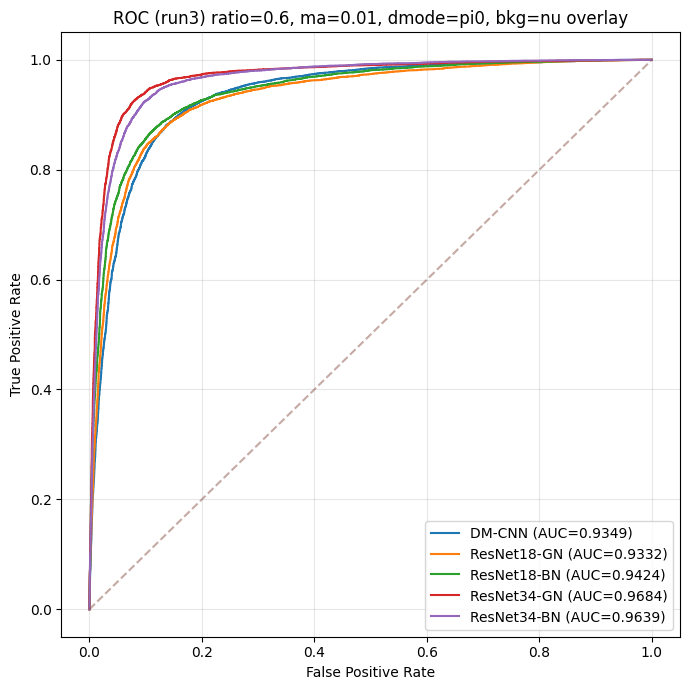

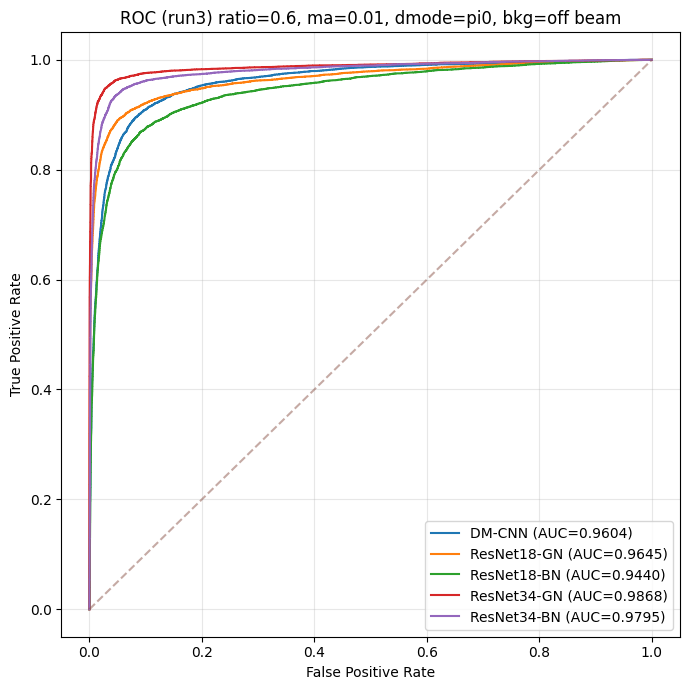

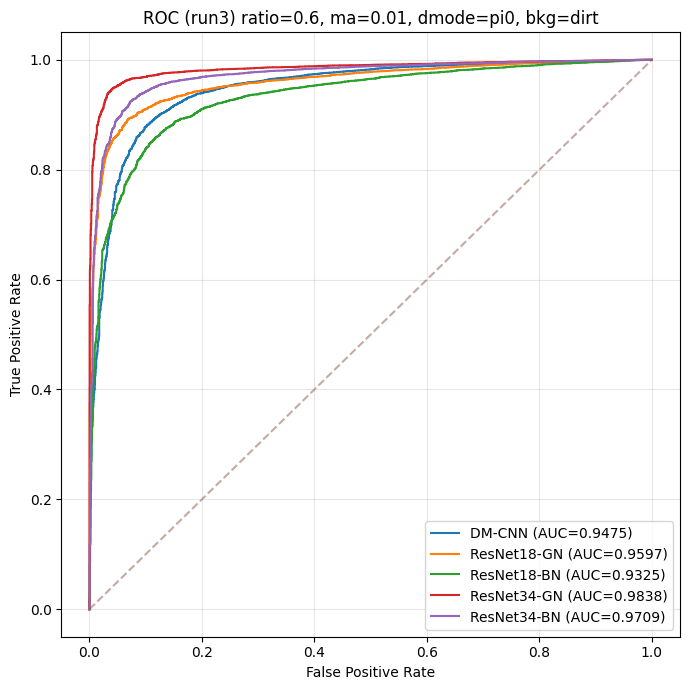

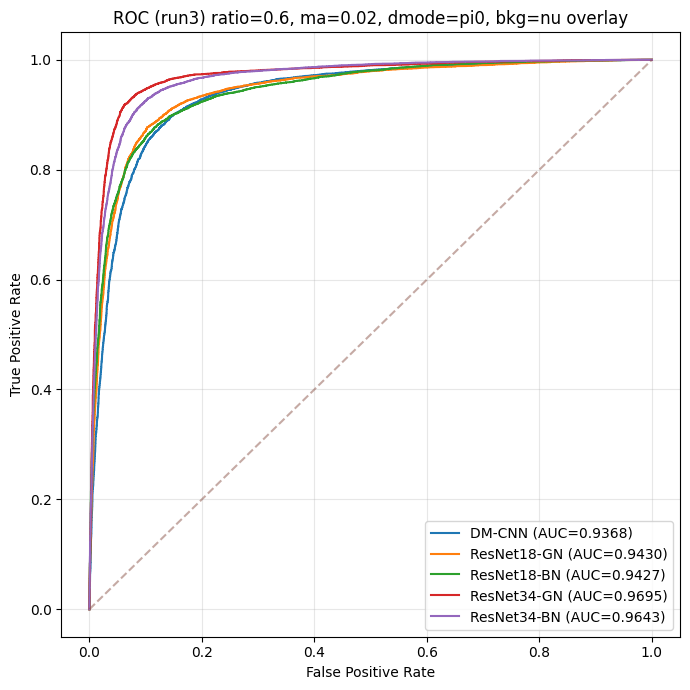

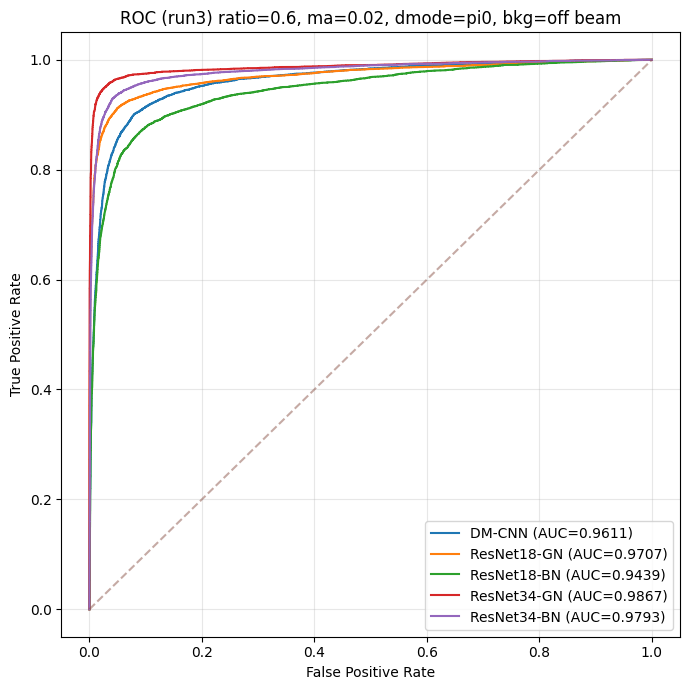

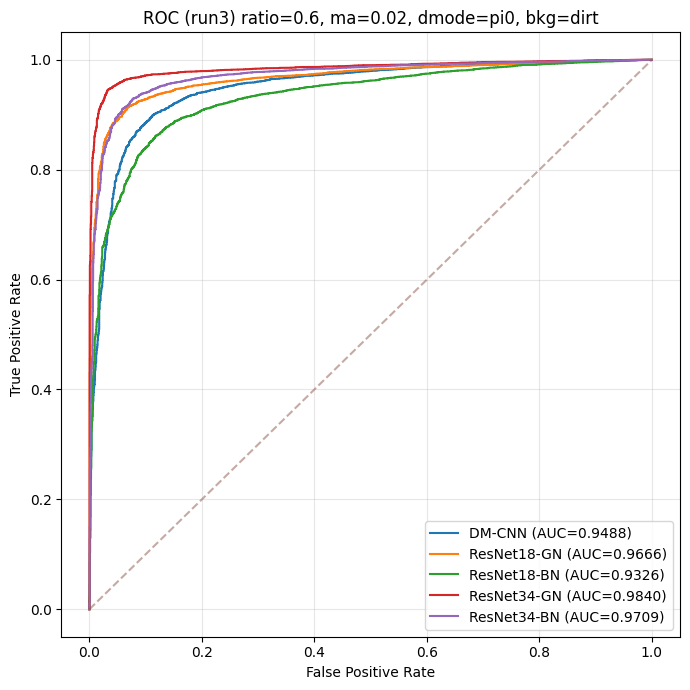

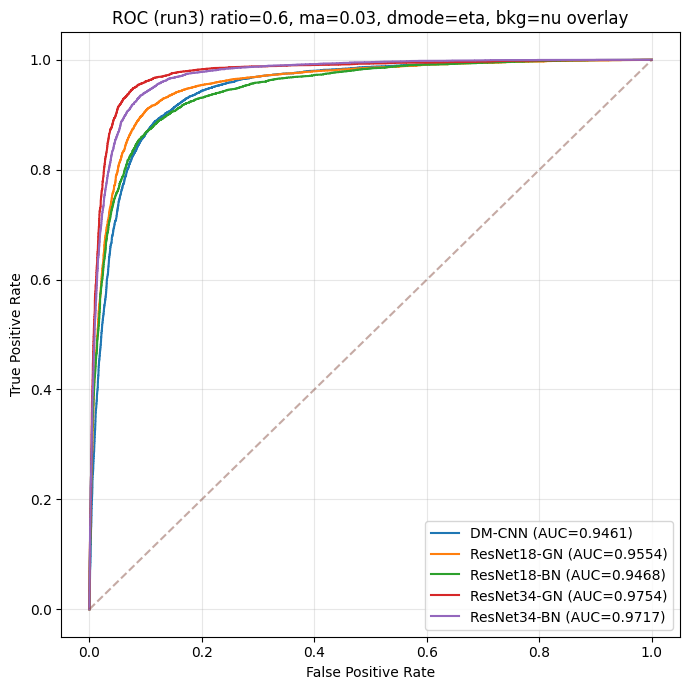

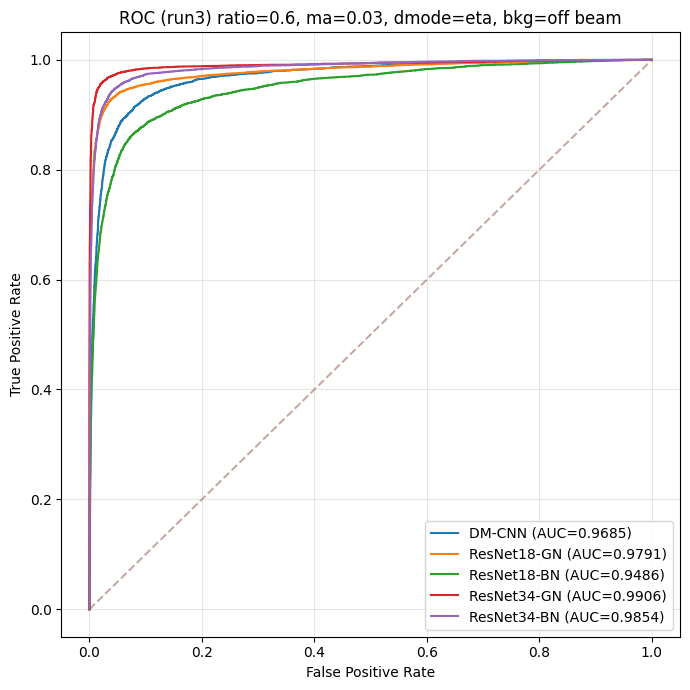

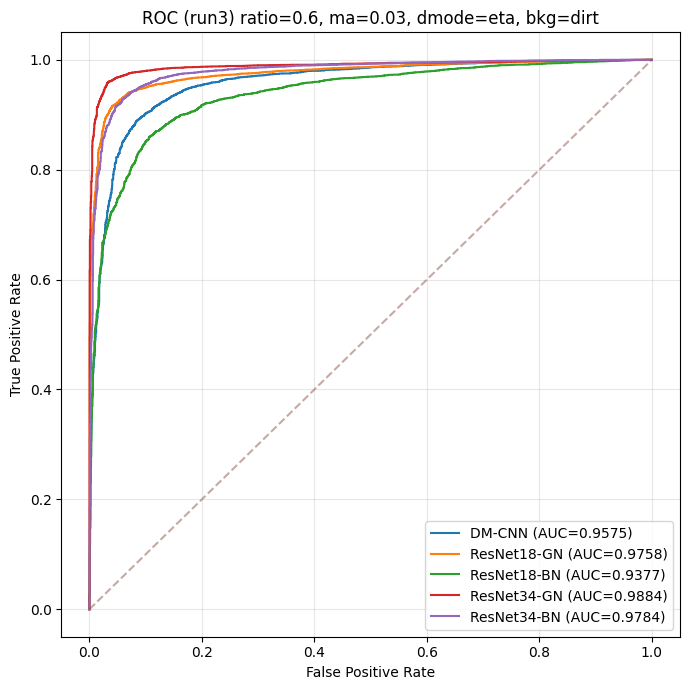

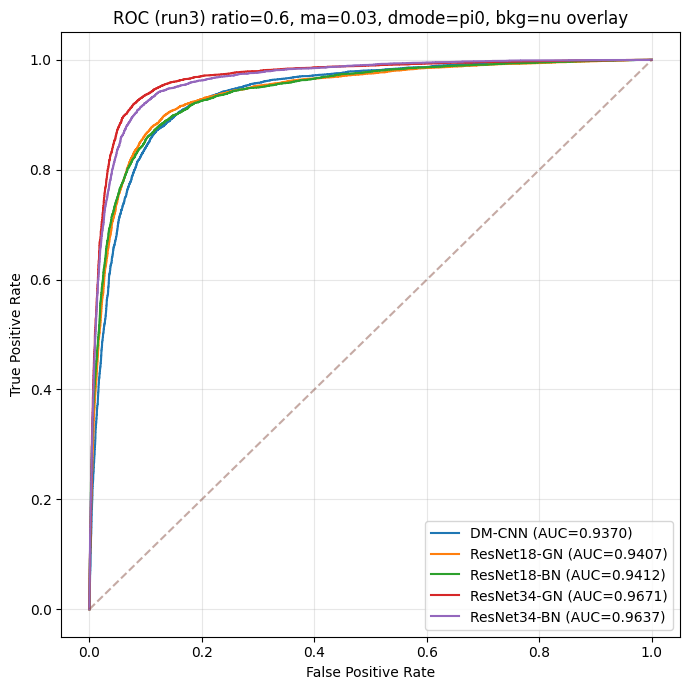

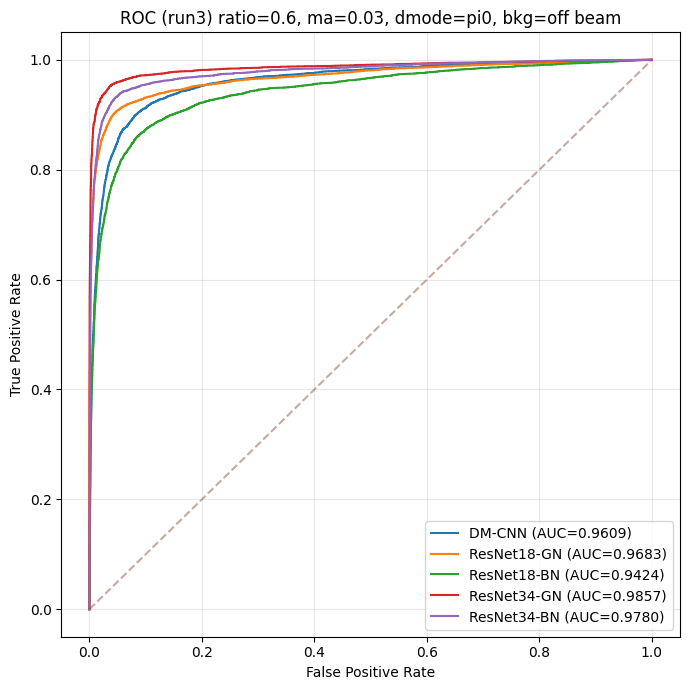

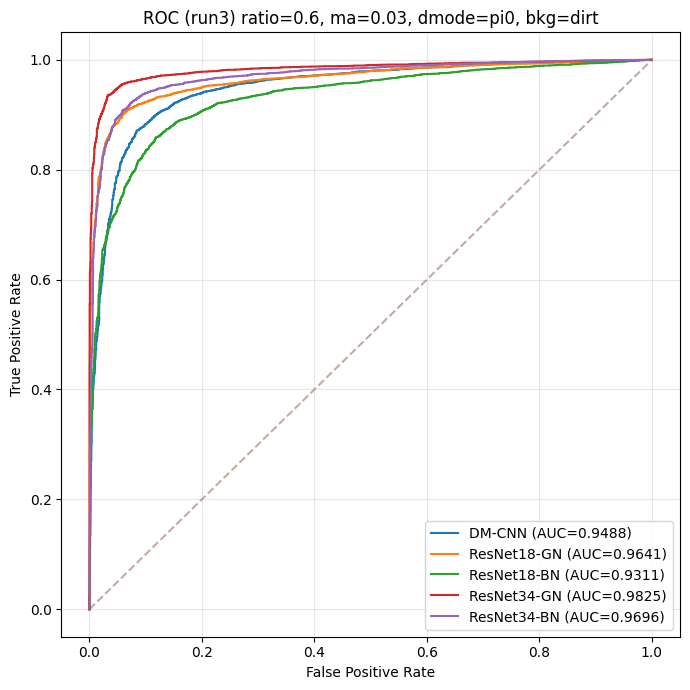

In [ ]:
# Parse ratio, mass, and dmode (pi0/eta) from filename
def parse_ratio_mass_dmode(fname):
    m = re.search(r"dt_ratio_([0-9.]+)_ma_([0-9.]+)_(pi0|eta)_", fname)
    if not m:
        return None, None, None
    return float(m.group(1)), float(m.group(2)), m.group(3)

RATIO = 0.6  # or 2.0
BKG_ORDER = ["nu overlay", "off beam", "dirt"]  # must match your dict keys

# Collect signal files for DM-CNN folder (use that as the "list of mass points")
sig_files = sorted(Path(MODELS["DM-CNN"]["sig_dir"]).glob("*_scores.csv"))

# Filter to ratio and keep (mass, dmode, Path)
sig_files_ratio = []
for f in sig_files:
    ratio, mass, dmode = parse_ratio_mass_dmode(f.name)
    if ratio is None:
        continue
    if abs(ratio - RATIO) < 1e-9:
        sig_files_ratio.append((mass, dmode, f))

sig_files_ratio = sorted(sig_files_ratio, key=lambda x: (x[0], x[1]))
print(f"Found {len(sig_files_ratio)} signal files for ratio={RATIO}")

# One figure per mass+dmode AND per background component, comparing models
for mass, dmode, f_dmcnn in sig_files_ratio:
    for bkg_comp in BKG_ORDER:
        plt.figure(figsize=(7, 7))

        any_plotted = False

        for model_name, cfg in MODELS.items():
            # pick the matching signal file name in that model's signal dir
            f_sig = Path(cfg["sig_dir"]) / f_dmcnn.name
            if not f_sig.exists():
                print(f"[skip] missing sig for {model_name}: {f_sig.name}")
                continue

            sig = load_scores_csv(f_sig, score_col=SCORE_COL)

            # bkg_scores[model] is now a dict of components
            if model_name not in bkg_scores or bkg_comp not in bkg_scores[model_name]:
                print(f"[skip] missing {bkg_comp} bkg for {model_name}")
                continue

            bkg = bkg_scores[model_name][bkg_comp]
            if len(bkg) == 0:
                print(f"[skip] empty {bkg_comp} bkg for {model_name}")
                continue

            fpr, tpr, auc_val = compute_roc_auc(bkg, sig)
            plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_val:.4f})")
            any_plotted = True

        if not any_plotted:
            plt.close()
            continue

        plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.5)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC (run3) ratio={RATIO}, ma={mass}, dmode={dmode}, bkg={bkg_comp}")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
